# Health Insurance Coverage in the US and Income

In the United States, health insurances are programs that help pay for medical expenses, whether through privately purchased insurance, social insurance or a social welfare program (e.g. Medicare & Medicaid) funded by the government.

Medicaid is the largest funding source for medical services for people of all ages with insufficient income and resources to pay for health care, so income level plays a major role in determining eligibility for Medicaid.

Medicaid is jointly funded by the state and federal goverments, and states have some flexibility in deciding who qualifies for coverage.

The Patient Protection and Affordable Care Act (ACA/"Obamacare"), most which took effect in 2014, significantly expanded eligibility for Medicaid, but states have the option of participating in the expansion or not. 

### What are the impacts of the ACA on health insurance coverage?

We aim to examine annual trends in health insurance coverage across the US, and demographic and economic differences in coverage status, using the American Community Survey (ACS) 1-Year Data (2012-2016). 2011 data were not used because health insurance coverage status was not available. We will create animated maps of uninsured rates for the whole US population by state, and explore different categories of insurance, as well as sub-populations with children, employed vs unemployed people in the labor force, and adults not in the labor force.

The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. Data files are available for the nation, all 50 states, the District of Columbia, Puerto Rico, every congressional district, every metropolitan area, and **all counties and places with populations of 65,000 or more**.

We will clean up and merge data from 2012-2016 on health insurance coverage and other relevant demographics in ACS, on a county level. To investigate the association between coverage status and income, we will examine descriptive statistics and develop a OLS regression model based on relevant demographic variables and income measured as median income, or categorized income group. To evaluate the effects of the ACA, we will use a difference-in-diffence model, comparing changes in uninsured rates in states participating in the Medicaid expansion vs states not participating.

Because Medicaid covers low income and disabled people while Medicare covers people aged 65 and older, and employers often provide insurance to employees, we anticipate that the middle-aged unemployed population is the most uninsured, and could benefit from policy changes implemented by the ACA. Hopefully, uninsured rates decreased more in Medicaid expansion states.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests, json
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/Users/shiyinjiao/anaconda/envs/py-geo/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


To start off, let's take a look at the health insurance coverage by state in 2016.

In [2]:
addr = "https://api.census.gov/data/2016/acs/acs1/profile?get=DP03_0096PE,NAME&for=state:*"
j = requests.get(addr).json()
with open("data/state_insurance_2016.csv", "w") as out:
    for obs in j:
        stateFIPS = obs[0]
        state = obs[1]
        insurance_coverage = obs[2]
        out.write(",".join([insurance_coverage, state, stateFIPS]) + "\n")

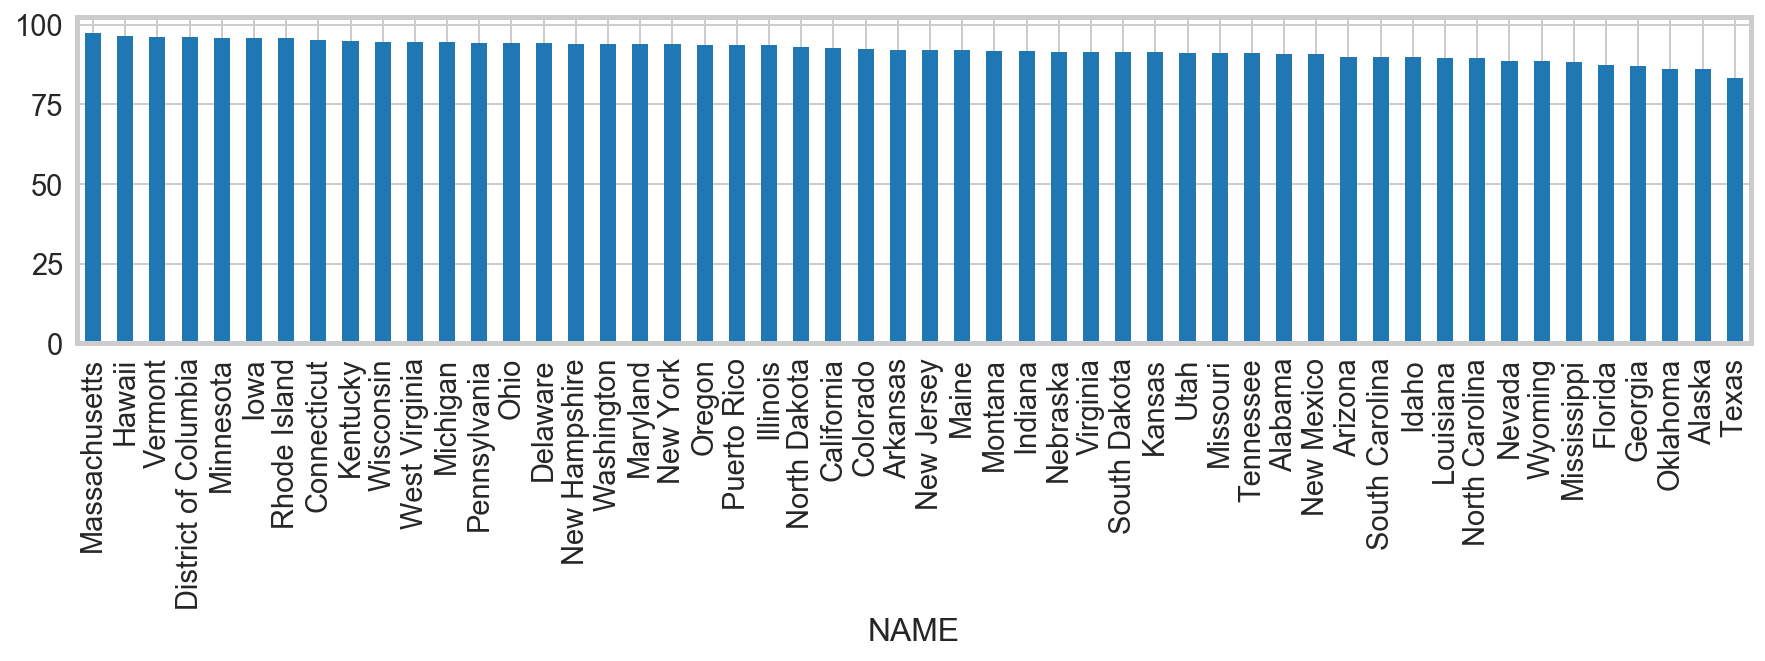

In [3]:
insurance_df = pd.read_csv("data/state_insurance_2016.csv", index_col = "state")
insurance_df.rename(columns = {"NAME" : "State", "DP03_0096PE" : "Health Insurance Coverage"}, inplace = True)
geo_df = gpd.read_file("data/cb_2016_us_state_20m/cb_2016_us_state_20m.shp")
geo_df.set_index(geo_df["STATEFP"].astype(int), inplace = True)
geo_merge = geo_df.join(insurance_df, how = "inner")
geo_merge.set_index("NAME")["Health Insurance Coverage"]\
         .sort_values(ascending = False)\
         .plot(kind = "bar", figsize = (15, 3))

Overall, the percentage with health insurance coverage is quite high, ranging from ~80% to ~100%. Massachusetts has the highest insured rate and Texas has the lowest.

Let's look at health insurance coverage in a US map.

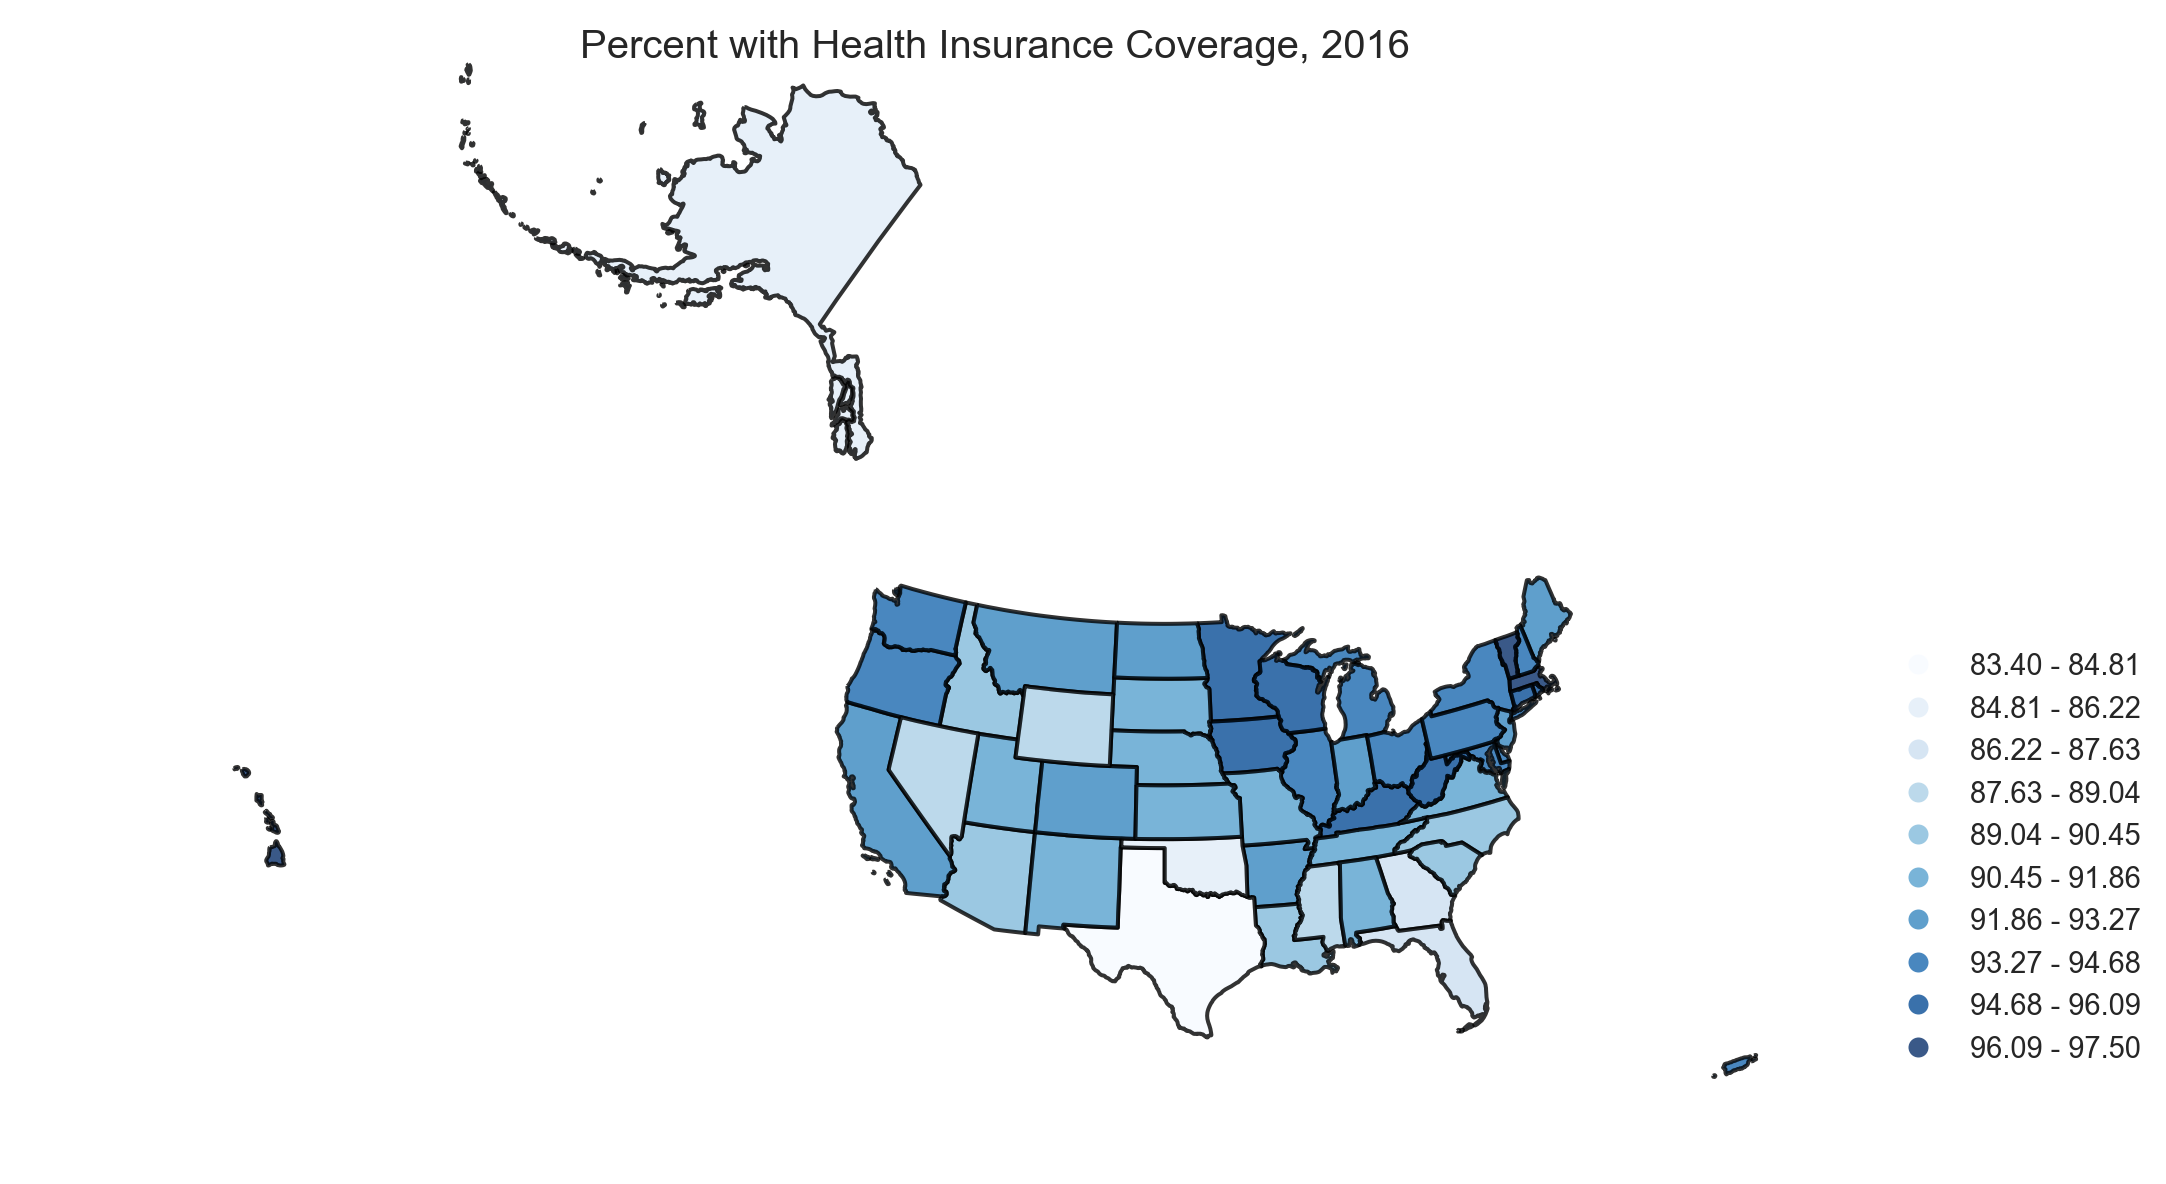

In [4]:
albers = geo_merge.to_crs(epsg=2163)
ax = albers.plot(column = "Health Insurance Coverage", cmap = "Blues", scheme = "equal_interval", k = 10, 
                 legend = True, alpha = 0.8, linewidth = 2, edgecolor = "black", figsize = (15, 15))

ax.set_title("Percent with Health Insurance Coverage, 2016", fontsize = 20, y = 0.95)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((1.2, 0.45))
ax.get_legend().get_frame().set_linewidth(0)

The northeast region and the northern states appear to have higher percentages of insurance coverage.

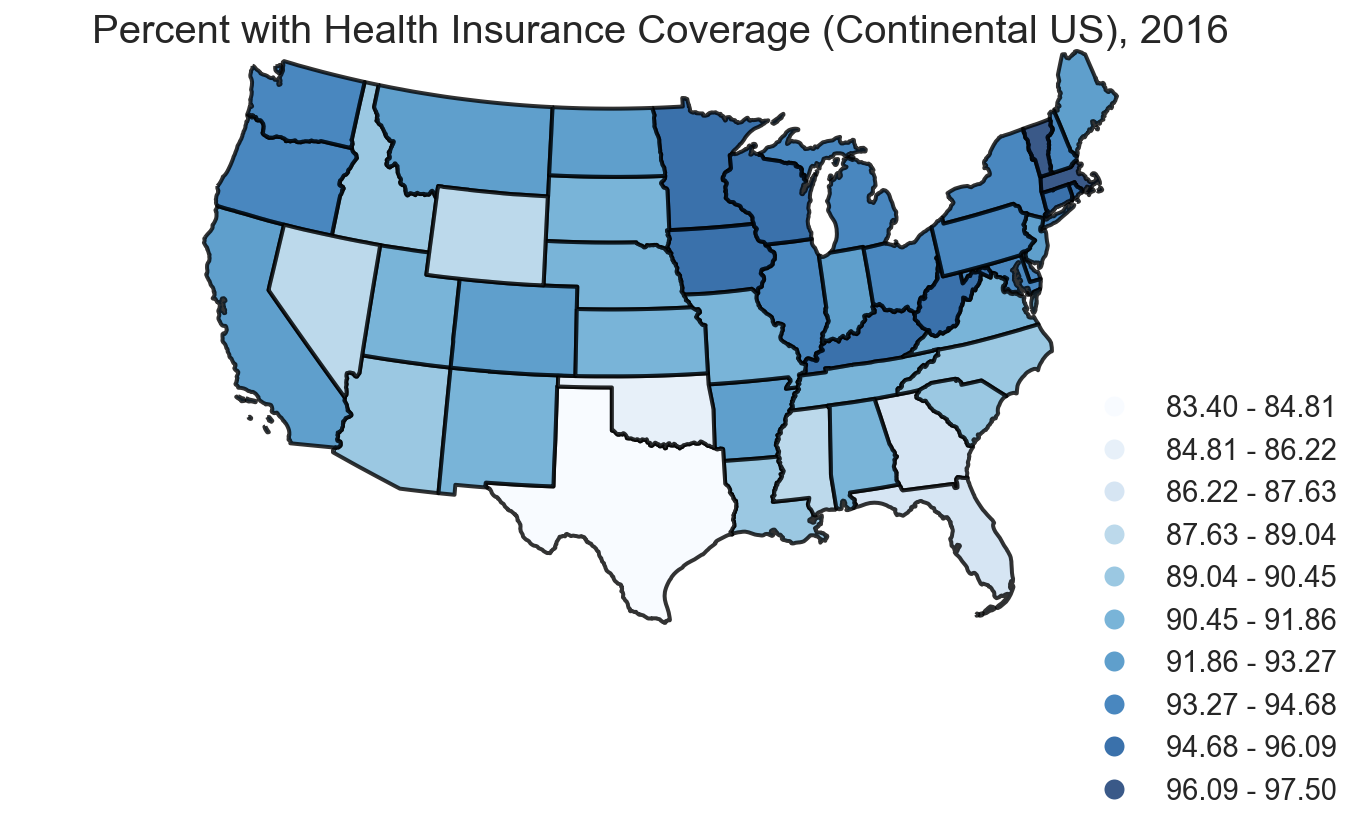

In [5]:
# Excluding Alaska, Hawaii, and the territories:
contiguous =  (geo_df.index < 57)
contiguous &= (geo_df.index != 15)
contiguous &= (geo_df.index != 2)
geo_df_contiguous = geo_df[contiguous]
geo_contiguous_merge = geo_df_contiguous.join(insurance_df, how = "inner")

albers = geo_contiguous_merge.to_crs(epsg=2163)
ax = albers.plot(column = "Health Insurance Coverage", cmap = "Blues", scheme = "equal_interval", k = 10, 
                 legend = True, alpha = 0.8, linewidth = 2, edgecolor = "black", figsize = (9, 9))

ax.set_title("Percent with Health Insurance Coverage (Continental US), 2016", fontsize = 20, y = 0.95)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((1.2, 0.45))
ax.get_legend().get_frame().set_linewidth(0)

Now we will import county-level data from all years. Because the ACS API has a limit on the number of variable queries, we'll split our desired variables in separate lists and merge them into a large dataframe after importing.

In [6]:
#age
a0 = "DP05_0004PE,DP05_0005PE,DP05_0006PE,DP05_0007PE,DP05_0008PE,DP05_0009PE,DP05_0010PE,DP05_0011PE,DP05_0012PE,DP05_0013PE,DP05_0021PE,DP05_0018PE"
#sex, race, employment status
a1 = "DP05_0002PE,DP05_0072PE,DP05_0073PE,DP05_0066PE,DP03_0005PE"
#income
a2 = "DP03_0062E,DP03_0052PE,DP03_0053PE,DP03_0054PE,DP03_0055PE,DP03_0056PE,DP03_0057PE,DP03_0058PE,DP03_0059PE,DP03_0060PE,DP03_0061PE"
#educational attainment
a3 = "DP02_0059PE,DP02_0060PE,DP02_0061PE,DP02_0062PE,DP02_0063PE,DP02_0064PE"
#health insurance coverage
a4 = "DP03_0096PE,DP03_0097PE,DP03_0098PE,DP03_0099PE"
a5 = "DP03_0101PE,DP03_0106PE,DP03_0107PE,DP03_0108PE"
a6 = "DP03_0111PE,DP03_0112PE,DP03_0113PE,DP03_0116PE,DP03_0117PE,DP03_0118PE"

variable_list = [a0,a1,a2,a3,a4,a5,a6]

def get_data(level,year,variable):
    if (level == "county"):
        if (year > 2014):
            addr = "https://api.census.gov/data/{}/acs/acs1/profile?get=".format(year)
            addr = addr+variable+",NAME&for=county:*&in=state:*&key=fec0e41eb606865dc911dc580210adf7e94fac80"
        else:
            addr = "https://api.census.gov/data/{}/acs1/profile?get=".format(year)
            addr = addr+variable+",NAME&for=county:*&in=state:*&key=fec0e41eb606865dc911dc580210adf7e94fac80"
    else:
        if (year > 2014):
            addr = "https://api.census.gov/data/{}/acs/acs1/profile?get=".format(year)
            addr = addr+variable+",NAME&for=state:*&key=fec0e41eb606865dc911dc580210adf7e94fac80"
        else:
            addr = "https://api.census.gov/data/{}/acs1/profile?get=".format(year)
            addr = addr+variable+",NAME&for=state:*&key=fec0e41eb606865dc911dc580210adf7e94fac80"
    return requests.get(addr).json()

for year in range(2012, 2017):
    d0_year = pd.DataFrame(data = get_data("county",year,a0)[1:],columns = get_data("county",year,a0)[0])
    d1_year = pd.DataFrame(data = get_data("county",year,a1)[1:],columns = get_data("county",year,a1)[0])
    d2_year = pd.DataFrame(data = get_data("county",year,a2)[1:],columns = get_data("county",year,a2)[0])
    d3_year = pd.DataFrame(data = get_data("county",year,a3)[1:],columns = get_data("county",year,a3)[0])
    d4_year = pd.DataFrame(data = get_data("county",year,a4)[1:],columns = get_data("county",year,a4)[0])
    d5_year = pd.DataFrame(data = get_data("county",year,a5)[1:],columns = get_data("county",year,a5)[0])
    d6_year = pd.DataFrame(data = get_data("county",year,a6)[1:],columns = get_data("county",year,a6)[0])
        
    data_year = pd.merge(d0_year,d1_year,how='left',on=['NAME','state','county'])
    data_year = pd.merge(data_year,d2_year,how='left',on=['NAME','state','county'])
    data_year = pd.merge(data_year,d3_year,how='left',on=['NAME','state','county'])
    data_year = pd.merge(data_year,d4_year,how='left',on=['NAME','state','county'])
    data_year = pd.merge(data_year,d5_year,how='left',on=['NAME','state','county'])
    data_year = pd.merge(data_year,d6_year,how='left',on=['NAME','state','county'])
    
    filename = "acs_" + str(year) + ".csv"
    data_year.to_csv("data/" + filename)

Combine all years of data and make a big dataframe. <br>
Rename variables and re-categorize as needed. <br>
Although race/ethnicity seems to be an important predictor for uninsured rate, unfortunately its values are missing for 57,74,49 counties in years 2012,13,14, some of which are >5%. We decided not to include it in our regression.

In [7]:
insurance_combined = pd.DataFrame()
for year in range(2012,2017):
    filename = "acs_" + str(year) + ".csv"
    insurance_year = pd.read_csv("data/" + filename, index_col = ["county"])
    insurance_year.rename(columns = {"NAME":"County, State", "state":"State FIPS",
        #age
        "DP05_0004PE":"Under 5 years", "DP05_0005PE":"5 to 9 years", "DP05_0006PE":"10 to 14 years", 
        "DP05_0007PE":"15 to 19 years", "DP05_0008PE":"20 to 24 years", "DP05_0009PE":"25 to 34 years", 
        "DP05_0010PE":"35 to 44 years", "DP05_0011PE":"45 to 54 years", "DP05_0012PE":"55 to 59 years",
        "DP05_0013PE":"60 to 64 years", "DP05_0021PE":"65 years and over", "DP05_0018PE":"18 years and over",
        #sex, 
        #race (values missing for 57,74,49 counties in 2012,13,14, won't use in regression), 
        #employment status
        "DP05_0002PE":"Male", "DP05_0072PE":"Non-Hispanic White", "DP05_0073PE":"Non-Hispanic Black", 
        "DP05_0066PE":"Hispanic or Latino", "DP03_0005PE":"Unemployed (>=16 years,In civilian labor force)",
        #income
        "DP03_0062E":"Median household income", "DP03_0052PE":"Less than $10,000", "DP03_0053PE":"$10,000 to $14,999", 
        "DP03_0054PE":"$15,000 to $24,999", "DP03_0055PE":"$25,000 to $34,999", "DP03_0056PE":"$35,000 to $49,999", 
        "DP03_0057PE":"$50,000 to $74,999", "DP03_0058PE":"$75,000 to $99,999", "DP03_0059PE":"$100,000 to $149,999", 
        "DP03_0060PE":"$150,000 to $199,999", "DP03_0061PE":"$200,000 or more", 
        #educational attainment
        "DP02_0059PE":"Less than 9th grade", "DP02_0060PE":"9th to 12th grade, no diploma", "DP02_0061PE":"High school graduate", 
        "DP02_0062PE":"Some college, no degree", "DP02_0063PE":"Associate's degree", "DP02_0064PE":"Bachelor's degree",
        #health insurance coverage
        "DP03_0096PE":"With health insurance coverage", "DP03_0097PE":"With private health insurance", 
        "DP03_0098PE":"With public health insurance", "DP03_0099PE":"No health insurance coverage",
        "DP03_0101PE":"<18 years, No insurance", "DP03_0106PE":"18-64, Employed, With private insurance", 
        "DP03_0107PE":"18-64, Employed, With public insurance", "DP03_0108PE":"18-64, Employed, No insurance",
        "DP03_0111PE":"18-64, Unmployed, With private insurance", "DP03_0112PE":"18-64, Unmployed, With public insurance", 
        "DP03_0113PE":"18-64, Unmployed, No insurance", "DP03_0116PE":"18-64, Not in labor force, With private insurance", 
        "DP03_0117PE":"18-64, Not in labor force, With public insurance", "DP03_0118PE":"18-64, Not in labor force, No insurance"
        }, inplace = True)
    insurance_year.drop('Unnamed: 0', axis=1, inplace=True)
    insurance_year["Year"] = year
    
    #insurance_norace_year = insurance_year[insurance_year["Non-Hispanic White"]=="N"]
    #print(len(insurance_norace_year))
    
    # Re-Categorize
    insurance_year["Under 18 years"] = 100 - insurance_year["18 years and over"]
    insurance_year["18 - 64 years"] = insurance_year["18 years and over"] - insurance_year["65 years and over"]
    insurance_year["< High school"] = insurance_year["Less than 9th grade"] + insurance_year["9th to 12th grade, no diploma"]
    insurance_year["Associate's/Bachelor's degree"] = insurance_year["Associate's degree"] + insurance_year["Bachelor's degree"]
    insurance_year = insurance_year.apply(pd.to_numeric, errors='coerce')
        
    insurance_combined = insurance_combined.append(insurance_year)

insurance_2012 = insurance_combined[insurance_combined["Year"] == 2012]
insurance_2013 = insurance_combined[insurance_combined["Year"] == 2013]
insurance_2014 = insurance_combined[insurance_combined["Year"] == 2014]
insurance_2015 = insurance_combined[insurance_combined["Year"] == 2015]
insurance_2016 = insurance_combined[insurance_combined["Year"] == 2016]

Let's examine the variation in uninsured rates across income levels, in the whole US population and then within age and employment groups.

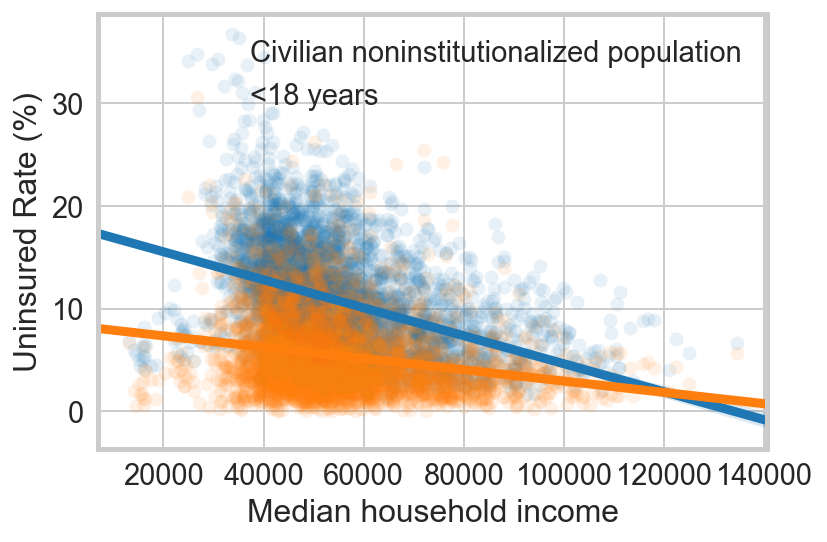

In [8]:
ax = sns.regplot(x = "Median household income", y = "No health insurance coverage", data = insurance_combined,
            scatter_kws = {"alpha" : 0.1}, label = "Civilian noninstitutionalized population")
ax = sns.regplot(x = "Median household income", y = "<18 years, No insurance", data = insurance_combined,
            scatter_kws = {"alpha" : 0.1}, label = "<18 years")
ax.set_ylabel("Uninsured Rate (%)")
ax.legend()
ax.figure.savefig("img/scatter1.png")

From all years combined and the whole civilian noninstitutionalized population (blue), we observe a negative relationship between median income and uninsured rate, but also a wide spread, especially at the lower end of income level.  Some counties with very low median household income have uninsured rates >30%, but some others have uninsured rates <5%.  

For the population under 18 years of age (orange), it seems the correlation is weaker, and the overall uninsured rate across all household income levels is lower among children.

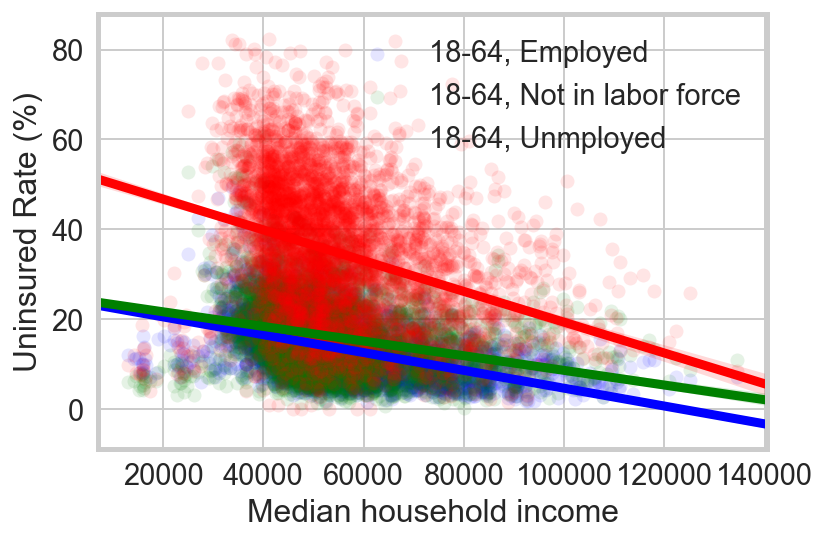

In [9]:
ax = sns.regplot(x = "Median household income", y = "18-64, Employed, No insurance", data = insurance_combined, 
                 scatter_kws = {"alpha" : 0.1}, color = "blue", label = "18-64, Employed")
ax = sns.regplot(x = "Median household income", y = "18-64, Not in labor force, No insurance", data = insurance_combined, 
                 scatter_kws = {"alpha" : 0.1}, color = "green", label = "18-64, Not in labor force")
ax = sns.regplot(x = "Median household income", y = "18-64, Unmployed, No insurance", data = insurance_combined, 
                 scatter_kws = {"alpha" : 0.1}, color = "red", label = "18-64, Unmployed")
ax.set_ylabel("Uninsured Rate (%)")
ax.legend()
ax.figure.savefig("img/scatter2.png")

For the population between 18-64 years of age, those who are in the labor force and employed have the lowest uninsured rates (blue), followed by those not in labor force (green). Uninsured rates are highest for people in the labor force but unemployed (red).

Other alternative specifications of income level, such as income-to-poverty ratio might better explain the variation on uninsured rates because of Medicaid policy, but our data do not allow such manipulation.

Next, we will perform regression analysis to examine the relationship between median household income and uninsured rates.

In [10]:
ols = smf.ols(formula = "uninsured ~ medincome + children + midage + male + unemployed + lessHS + HS + college + Bachelors + state",
              data = insurance_combined.rename(columns = {"No health insurance coverage"  : "uninsured", 
                                                          "Median household income"       : "medincome", 
                                                          "Under 18 years"                : "children",
                                                          "18 - 64 years"                 : "midage", 
                                                          "Male"                          : "male",
                                                          "Unemployed (>=16 years,In civilian labor force)": "unemployed",
                                                          "< High school"                 : "lessHS",
                                                          "High school graduate"          : "HS",
                                                          "Some college, no degree"       : "college",
                                                          "Associate's/Bachelor's degree" : "Bachelors",
                                                          "State FIPS"                    : "state"
                                                         }))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              uninsured   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     371.8
Date:                Fri, 01 Dec 2017   Prob (F-statistic):               0.00
Time:                        23:15:15   Log-Likelihood:                -11062.
No. Observations:                4080   AIC:                         2.215e+04
Df Residuals:                    4069   BIC:                         2.222e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9705      3.174      5.346      0.000      10.747      23.194
medincome     -0.0001   6.39e-06    -16.458      0.000      -0.000   -9.26e-05
children       0.2819      0.024     11.520      0.000       0.234       0.330
midage         0.0166      0.021      0.783      0.434      -0.025       0.058
male          -0.1409      0.052     -2.716      0.007      -0.243      -0.039
unemployed  2.359e-09   1.02e-09      2.321      0.020    3.66e-10    4.35e-09
lessHS         0.3691      0.028     13.001      0.000       0.313       0.425
HS            -0.1856      0.021     -8.887      0.000      -0.227      -0.145
college        0.1036      0.025      4.186      0.000       0.055       0.152
Bachelors     -0.0962      0.032     -2.978      0.003      -0.160      -0.033
state          0.0157      0.004      4.157      0.000       0.008       0.023
==============================================================================
Omnibus:                      101.212   Durbin-Watson:                   0.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.555
Skew:                           0.226   Prob(JB):                     6.81e-37
Kurtosis:                       3.881   Cond. No.                     3.14e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In this OLS regression, all coefficients are statistically significant except for midage. Implicitly, we are using the >65 years, female, employed, >Bachelors degree as the reference groups. <br>
All the coefficients are differences in percentage points between the comparison groups, and all are quite small in manitude.

Factors we found to have a beneficial effect of decreasing county-level uninsured rates: having higher median income, being male, and having high school diploma or Bachelor's degree compared to >Bachelor's. (Is higher educational attainment harmful???)

Although the directions of effect for some variables are not quite in line with our expectation, we should note that our sample size is very large (>800 counties in 5 years) which could make any small change statistically significant.

In [11]:
ols = smf.ols(formula = "uninsured ~ income1 + income2 + income3 + income4 + income5 + income6 + income7 + income8 + income9 + children + midage + male + unemployed + lessHS + HS + college + Bachelors + state",
              data = insurance_combined.rename(columns = {"No health insurance coverage"  : "uninsured",
                                                          "Less than $10,000"             : "income1",
                                                          "$10,000 to $14,999"            : "income2",
                                                          "$15,000 to $24,999"            : "income3",
                                                          "$25,000 to $34,999"            : "income4",
                                                          "$35,000 to $49,999"            : "income5",
                                                          "$50,000 to $74,999"            : "income6",
                                                          "$75,000 to $99,999"            : "income7",
                                                          "$100,000 to $149,999"          : "income8",
                                                          "$150,000 to $199,999"          : "income9",
                                                          "Under 18 years"                : "children",
                                                          "18 - 64 years"                 : "midage", 
                                                          "Male"                          : "male",
                                                          "Unemployed (>=16 years,In civilian labor force)": "unemployed",
                                                          "< High school"                 : "lessHS",
                                                          "High school graduate"          : "HS",
                                                          "Some college, no degree"       : "college",
                                                          "Associate's/Bachelor's degree" : "Bachelors",
                                                          "State FIPS"                    : "state"
                                                         }))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              uninsured   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     223.8
Date:                Fri, 01 Dec 2017   Prob (F-statistic):               0.00
Time:                        23:15:15   Log-Likelihood:                -10981.
No. Observations:                4080   AIC:                         2.200e+04
Df Residuals:                    4061   BIC:                         2.212e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8376      4.263      3.246      0.001       5.479      22.196
income1       -0.0406      0.046     -0.878      0.380      -0.131       0.050
income2       -0.1924      0.060     -3.191      0.001      -0.311      -0.074
income3       -0.1007      0.051     -1.984      0.047      -0.200      -0.001
income4        0.0117      0.052      0.224      0.823      -0.091       0.114
income5       -0.0199      0.048     -0.417      0.676      -0.113       0.073
income6       -0.0639      0.043     -1.470      0.142      -0.149       0.021
income7       -0.3570      0.048     -7.480      0.000      -0.451      -0.263
income8       -0.3263      0.049     -6.637      0.000      -0.423      -0.230
income9       -0.1859      0.081     -2.294      0.022      -0.345      -0.027
children       0.3040      0.024     12.473      0.000       0.256       0.352
midage         0.0713      0.022      3.237      0.001       0.028       0.115
male          -0.1693      0.051     -3.298      0.001      -0.270      -0.069
unemployed  2.095e-09   9.99e-10      2.098      0.036    1.37e-10    4.05e-09
lessHS         0.4172      0.028     14.666      0.000       0.361       0.473
HS            -0.0929      0.024     -3.944      0.000      -0.139      -0.047
college        0.1955      0.027      7.237      0.000       0.143       0.248
Bachelors      0.0086      0.034      0.256      0.798      -0.057       0.074
state          0.0163      0.004      4.392      0.000       0.009       0.024
==============================================================================
Omnibus:                      106.144   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.694
Skew:                           0.250   Prob(JB):                     3.85e-37
Kurtosis:                       3.859   Cond. No.                     4.30e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With such refined categories of household income, many of the coefficients become insignificant. We can see that compared to the "\$200,000 or more" income group, county-level uninsured rates is significantly lower for a higher percentage of people in income groups "\$10,000 to \$14,999", or between \$75,000 to \$199,999. Maybe the extremely rich people don't even care to have insurance?

### Impacts of the ACA on Health Insurance Coverage in Medicaid Expansion and Non-Expansion States

In our main specifications, we classify the 27 states that expanded Medicaid in 2014 as the treatment group for the Medicaid expansion and the other 24 as the control group (according to Kaiser Family Foundation). Our results should be interpreted as capturing only the effects of the 2014 Medicaid expansion, which might be smaller than the total effects of all the Medicaid expansions that occurred after the implementation of the ACA in 2010.

Expansion states: Arizona, California, Connecticut, Colorado, Delaware, Hawaii, Illinois, Iowa, Maryland, Massachusetts, Minnesota, New Jersey, New York, Oregon, Rhode Island, Vermont, Washington, Washington DC, Arkansas, Kentucky, Michigan, Nevada, New Hampshire, New Mexico, North Dakota, Ohio, and West Virginia.

We will identify the State FIPS codes of these expansion states and create dummy variables to indicate whether a state is an expansion state.

**Difference-in-Difference Model**:

$y_{ist} = β_0 + β_1Post_t + β_2(Medicaid_s × Post_t) + β_3X_{ist} + α_{s} + ε_{ist}$

where $y_{ist}$ is the uninsured rate for county $i$ in state $s$ in year $t$, <br>
$Post_t$ is an indicator for whether period $t$ is in the post-treatment year (2015, 2016), <br>
$Medicaid_s$ is an indicator for whether state $s$ participated in the ACA’s 2014 Medicaid expansion, <br>
$X_{ist}$ is a vector of control variables as identified in the previous regression, <br>
$α_s$ is a state fixed effect, and <br>
$ε_{ist}$ is the error term.

In [12]:
expansion_list = [4,5,6,8,9,10,11,15,17,19,21,24,25,26,27,32,33,34,35,36,38,39,41,44,50,53,54]
post_year = [2015, 2016]
Medicaid = [0] * len(insurance_combined["State FIPS"])
Post = [0] * len(insurance_combined["State FIPS"])
for i in range(len(insurance_combined["State FIPS"])):
    if insurance_combined.iloc[i]["State FIPS"] in expansion_list:
        Medicaid[i] = 1
    if insurance_combined.iloc[i]["Year"] in post_year:
        Post[i] = 1
insurance_combined["Medicaid"] = Medicaid
insurance_combined["Post"] = Post

In [13]:
ols = smf.ols(formula = "uninsured ~ Post + Medicaid * Post + medincome + children + midage + male + unemployed + lessHS + HS + college + Bachelors + state",
              data = insurance_combined.rename(columns = {"No health insurance coverage"  : "uninsured", 
                                                          "Median household income"       : "medincome", 
                                                          "Under 18 years"                : "children",
                                                          "18 - 64 years"                 : "midage",  
                                                          "Male"                          : "male",
                                                          "Unemployed (>=16 years,In civilian labor force)": "unemployed",
                                                          "< High school"                 : "lessHS",
                                                          "High school graduate"          : "HS",
                                                          "Some college, no degree"       : "college",
                                                          "Associate's/Bachelor's degree" : "Bachelors",
                                                          "State FIPS"                    : "state",
                                                          "Post": "Post", "Medicaid": "Medicaid"
                                                         }))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              uninsured   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     614.7
Date:                Fri, 01 Dec 2017   Prob (F-statistic):               0.00
Time:                        23:15:17   Log-Likelihood:                -10169.
No. Observations:                4080   AIC:                         2.037e+04
Df Residuals:                    4066   BIC:                         2.045e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.5697      2.555      6.486      0.000      11.561      21.578
Post             -3.2081      0.129    -24.939      0.000      -3.460      -2.956
Medicaid         -2.5746      0.124    -20.813      0.000      -2.817      -2.332
Medicaid:Post    -0.8782      0.188     -4.670      0.000      -1.247      -0.510
medincome     -5.606e-05   5.25e-06    -10.673      0.000   -6.64e-05   -4.58e-05
children          0.1304      0.020      6.547      0.000       0.091       0.170
midage           -0.0467      0.017     -2.729      0.006      -0.080      -0.013
male              0.0209      0.042      0.498      0.618      -0.061       0.103
unemployed      9.87e-10   8.19e-10      1.206      0.228   -6.18e-10    2.59e-09
lessHS            0.3969      0.023     17.371      0.000       0.352       0.442
HS               -0.1927      0.017    -11.471      0.000      -0.226      -0.160
college           0.1209      0.020      6.080      0.000       0.082       0.160
Bachelors        -0.1040      0.026     -3.998      0.000      -0.155      -0.053
state            -0.0020      0.003     -0.631      0.528      -0.008       0.004
==============================================================================
Omnibus:                      199.462   Durbin-Watson:                   1.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              360.985
Skew:                           0.378   Prob(JB):                     4.10e-79
Kurtosis:                       4.246   Cond. No.                     3.14e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$β_1 = -3.21$ (percentage points) represents the effect of the non-Medicaid components of the ACA (insurance market reforms, individual mandate, subsidies, exchanges). <br>
$β_2 = -0.88$ (percentage points) is the effect of the Medicaid expansion. <br>
$β_1 + β_2 = -4.09$ (percentage points) gives the impact of the fully implemented ACA on uninsured rates. <br>
$β_1$ is the impact of the ACA without the Medicaid expansion. 

Although the directions of effect for some variables are not quite in line with our expectation, we should note that our sample size is very large (>800 counties in 5 years) which could make any small change statistically significant. 

From our diff-in-diff model, we found a 4.09 percentage points decrease in uninsured rate, that represents the effect of the fully implemented ACA. Within this 4.09 percentage points decrease, 3.21 percentage points is from the non-Medicaid components of the ACA, and 0.88 percentage points is the effect of The Medicaid expansion.

Interpreting these coefficients as causal requires many assumptions that are likely to be violated: in the absence of the ACA, conditional on the controls, there would have been no changes in the uninsured rates in post years; changes in uninsured rates in post years would have been the same in expansion and non-expansion states if the expansion had not occurred.

These are strong assumptions because insurance coverage patterns fluctuate over time and the politics associated with Medicaid expansion is extremely complicated. They could potentially be tested by ploting uninsured rates across years as shown in another jupyter notebook, but we will omit more rigorous robustness checks given the limited scope of our project.